# Load Tensorflow and check GPU availability

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2024-05-20 16:09:32.941458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 16:09:32.941484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 16:09:32.942231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 16:09:32.946477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 16:09:33.561024: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2024-05-20 16:09:34.336792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-05-20 16:09:34.341849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 1178 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [27]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/lex-benign_2312_anonymized.parquet',
    '../feature-extraction/floor/lex-umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
# df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



df

Total samples: 1645911
Benign count: 815517
Malicious count: 830394


,label,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_benign_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_tld_hash,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,lex_sld_phishing_keyword_count,lex_sld_vowel_count,lex_sld_vowel_ratio,lex_sld_consonant_count,lex_sld_consonant_ratio,lex_sld_non_alphanum_count,lex_sld_non_alphanum_ratio,lex_sld_hex_count,lex_sld_hex_ratio,lex_sub_count,lex_stld_unique_char_count,lex_begins_with_digit,lex_www_flag,lex_sub_max_consonant_len,lex_sub_norm_entropy,lex_sub_digit_count,lex_sub_digit_ratio,lex_sub_vowel_count,lex_sub_vowel_ratio,lex_sub_consonant_count,lex_sub_consonant_ratio,lex_sub_non_alphanum_count,lex_sub_non_alphanum_ratio,lex_sub_hex_count,lex_sub_hex_ratio,lex_phishing_bigram_matches,lex_phishing_trigram_matches,lex_phishing_tetragram_matches,lex_phishing_pentagram_matches,lex_malware_bigram_matches,lex_malware_trigram_matches,lex_malware_tetragram_matches,lex_dga_bigram_matches,lex_dga_trigram_matches,lex_dga_tetragram_matches,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_short_part_count,lex_medium_part_count,lex_long_part_count,lex_superlong_part_count,lex_shortest_sub_len,lex_ipv4_in_domain,lex_has_trusted_suffix,lex_has_wellknown_suffix,lex_has_cdn_suffix,lex_has_vps_suffix,lex_has_img_suffix,lex_suffix_score
0,benign,20,1,0,0,1,5,0.0000,1212505503,14,0.227286,3.0,0.214286,0,6,0.428571,4,0.285714,1,0.071429,7,0.500000,0,12,1,0,1,0.227286,3.0,0.214286,6,0.428571,4,0.285714,1,0.071429,7,0.500000,9,6,0,1,9,7,0,11,2,0,6.000000,5.656854,14,2,0,1,0,14,0,0,0,0,0,0,0
1,benign,44,1,0,1,2,3,0.0081,3139224157,10,0.312193,0.0,0.000000,0,3,0.300000,7,0.700000,0,0.000000,3,0.300000,2,10,1,0,4,0.098364,2.0,0.052632,10,0.263158,20,0.526316,6,0.157895,17,0.447368,22,18,4,6,21,16,8,24,8,1,10.250000,8.982622,25,2,1,1,0,38,0,0,0,0,0,0,0
2,benign,55,1,1,1,2,9,0.0000,2117195293,5,0.464386,0.0,0.000000,0,2,0.400000,3,0.600000,0,0.000000,3,0.600000,2,11,1,0,3,0.090476,1.0,0.023256,14,0.325581,25,0.581395,3,0.069767,18,0.418605,32,28,5,8,35,30,8,33,19,8,8.333333,9.551033,29,3,2,1,0,43,0,0,0,0,0,0,0
3,benign,56,1,0,0,2,9,0.0000,2117195293,5,0.464386,0.0,0.000000,0,2,0.400000,3,0.600000,0,0.000000,3,0.600000,2,11,1,0,5,0.092118,1.0,0.022727,15,0.340909,27,0.613636,3,0.068182,14,0.318182,29,23,4,6,30,28,3,32,17,8,8.500000,9.912114,30,3,2,1,0,44,0,0,0,0,0,0,0
4,benign,62,1,0,1,2,3,0.0081,3139224157,10,0.312193,0.0,0.000000,0,3,0.300000,7,0.700000,0,0.000000,3,0.300000,2,10,1,0,5,0.071321,3.0,0.053571,12,0.214286,29,0.517857,12,0.214286,18,0.321429,33,25,7,9,27,21,7,31,10,1,14.750000,16.558608,43,2,1,0,1,56,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830389,dga,14,0,0,0,2,3,0.6554,3649657627,10,0.312193,0.0,0.000000,0,2,0.200000,8,0.800000,0,0.000000,1,0.100000,0,10,0,0,8,0.312193,0.0,0.000000,2,0.200000,8,0.800000,0,0.000000,1,0.100000,2,0,0,0,3,0,0,9,3,0,6.500000,3.500000,10,1,1,0,0,10,0,0,0,0,0,0,0
830390,dga,19,0,0,0,1,3,0.1040,3946931378,15,0.242682,0.0,0.000000,0,4,0.266667,11,0.733333,0,0.000000,2,0.133333,0,14,0,0,4,0.242682,0.0,0.000000,4,0.266667,11,0.733333,0,0.000000,2,0.133333,6,1,0,0,8,2,0,14,10,0,9.000000,6.000000,15,1,0,1,0,15,0,0,0,0,0,0,0
830391,dga,15,0,1,0,1,4,0.0043,3105607653,10,0.312193,0.0,0.000000,0,3,0.300000,9,0.900000,0,0.000000,1,0.100000,0,12,0,0,8,0.312193,0.0,0.000000,3,0.300000,9,0.900000,0,0.000000,1,0.100000,4,1,0,0,4,1,0,9,1,0,7.000000,3.000000,10,0,2,0,0,10,0,0,0,0,0,0,0
830392,dga,32,1,0,0,1,3,0.1040,3946931378,28,0.145716,10.0,0.357143,0,4,0.142857,15,0.535714,0,0.000000,12,0.428571,0,21,1,0,4,0.145716,10.0,0.357143,4,0.142857,15,0.535714,0,0.000000,12,0.428571,6,1,0,0,7,3,0,20,3,0,15.500000,12.500000,28,1,0,1,0,28,0,0,0,0,0,0,0


# Data preprocessing

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "dga_binary_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_benign_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_tld_hash,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,lex_sld_phishing_keyword_count,lex_sld_vowel_count,lex_sld_vowel_ratio,lex_sld_consonant_count,lex_sld_consonant_ratio,lex_sld_non_alphanum_count,lex_sld_non_alphanum_ratio,lex_sld_hex_count,lex_sld_hex_ratio,lex_sub_count,lex_stld_unique_char_count,lex_begins_with_digit,lex_www_flag,lex_sub_max_consonant_len,lex_sub_norm_entropy,lex_sub_digit_count,lex_sub_digit_ratio,lex_sub_vowel_count,lex_sub_vowel_ratio,lex_sub_consonant_count,lex_sub_consonant_ratio,lex_sub_non_alphanum_count,lex_sub_non_alphanum_ratio,lex_sub_hex_count,lex_sub_hex_ratio,lex_phishing_bigram_matches,lex_phishing_trigram_matches,lex_phishing_tetragram_matches,lex_phishing_pentagram_matches,lex_malware_bigram_matches,lex_malware_trigram_matches,lex_malware_tetragram_matches,lex_dga_bigram_matches,lex_dga_trigram_matches,lex_dga_tetragram_matches,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_short_part_count,lex_medium_part_count,lex_long_part_count,lex_superlong_part_count,lex_shortest_sub_len,lex_ipv4_in_domain,lex_has_trusted_suffix,lex_has_wellknown_suffix,lex_has_cdn_suffix,lex_has_vps_suffix,lex_has_img_suffix,lex_suffix_score
0,0.109589,1.0,0.00,0.00,0.000000,0.172414,0.000000,0.259141,0.225806,0.430205,0.100000,0.214286,0.0,0.101695,0.428571,0.088889,0.285714,0.038462,0.142857,0.175,0.500000,0.000000,0.354839,1.0,0.0,0.017544,0.430205,0.057692,0.214286,0.101695,0.428571,0.0500,0.285714,0.038462,0.142857,0.089744,0.500000,0.163636,0.117647,0.000000,0.023256,0.176471,0.145833,0.000000,0.127907,0.046512,0.000000,0.147368,0.191758,0.196721,0.250,0.000,0.25,0.0,0.102190,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.273973,1.0,0.00,0.25,0.017544,0.103448,0.012359,0.722221,0.161290,0.590915,0.000000,0.000000,0.0,0.050847,0.300000,0.155556,0.700000,0.000000,0.000000,0.075,0.300000,0.222222,0.290323,1.0,0.0,0.070175,0.186182,0.038462,0.052632,0.169492,0.263158,0.2500,0.526316,0.230769,0.315789,0.217949,0.447368,0.400000,0.352941,0.102564,0.139535,0.411765,0.333333,0.275862,0.279070,0.186047,0.052632,0.281579,0.304496,0.377049,0.250,0.125,0.25,0.0,0.277372,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.349315,1.0,0.25,0.25,0.017544,0.310345,0.000000,0.476580,0.080645,0.878984,0.000000,0.000000,0.0,0.033898,0.400000,0.066667,0.600000,0.000000,0.000000,0.075,0.600000,0.222222,0.322581,1.0,0.0,0.052632,0.171252,0.019231,0.023256,0.237288,0.325581,0.3125,0.581395,0.115385,0.139535,0.230769,0.418605,0.581818,0.549020,0.128205,0.186047,0.686275,0.625000,0.275862,0.383721,0.441860,0.421053,0.221053,0.323764,0.442623,0.375,0.250,0.25,0.0,0.313869,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.356164,1.0,0.00,0.00,0.017544,0.310345,0.000000,0.476580,0.080645,0.878984,0.000000,0.000000,0.0,0.033898,0.400000,0.066667,0.600000,0.000000,0.000000,0.075,0.600000,0.222222,0.322581,1.0,0.0,0.087719,0.174360,0.019231,0.022727,0.254237,0.340909,0.3375,0.613636,0.115385,0.136364,0.179487,0.318182,0.527273,0.450980,0.102564,0.139535,0.588235,0.583333,0.103448,0.372093,0.395349,0.421053,0.226316,0.336004,0.459016,0.375,0.250,0.25,0.0,0.321168,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.397260,1.0,0.00,0.25,0.017544,0.103448,0.012359,0.722221,0.161290,0.590915,0.000000,0.000000,0.0,0.050847,0.300000,0.155556,0.700000,0.000000,0.000000,0.075,0.300000,0.222222,0.290323,1.0,0.0,0.087719,0.134996,0.057692,0.053571,0.203390,0.214286,0.3625,0.517857,0.461538,0.428571,0.230769,0.321429,0.600000,0.490196,0.179487,0.209302,0.529412,0.437500,0.241379,0.360465,0.232558,0.052632,0.423684,0.561309,0.672131,0.250,0.125,0.00,0.5,0.408759,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645906,

# Train-test split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(62,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[Precision(), Recall(), AUC()]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                4032      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)               

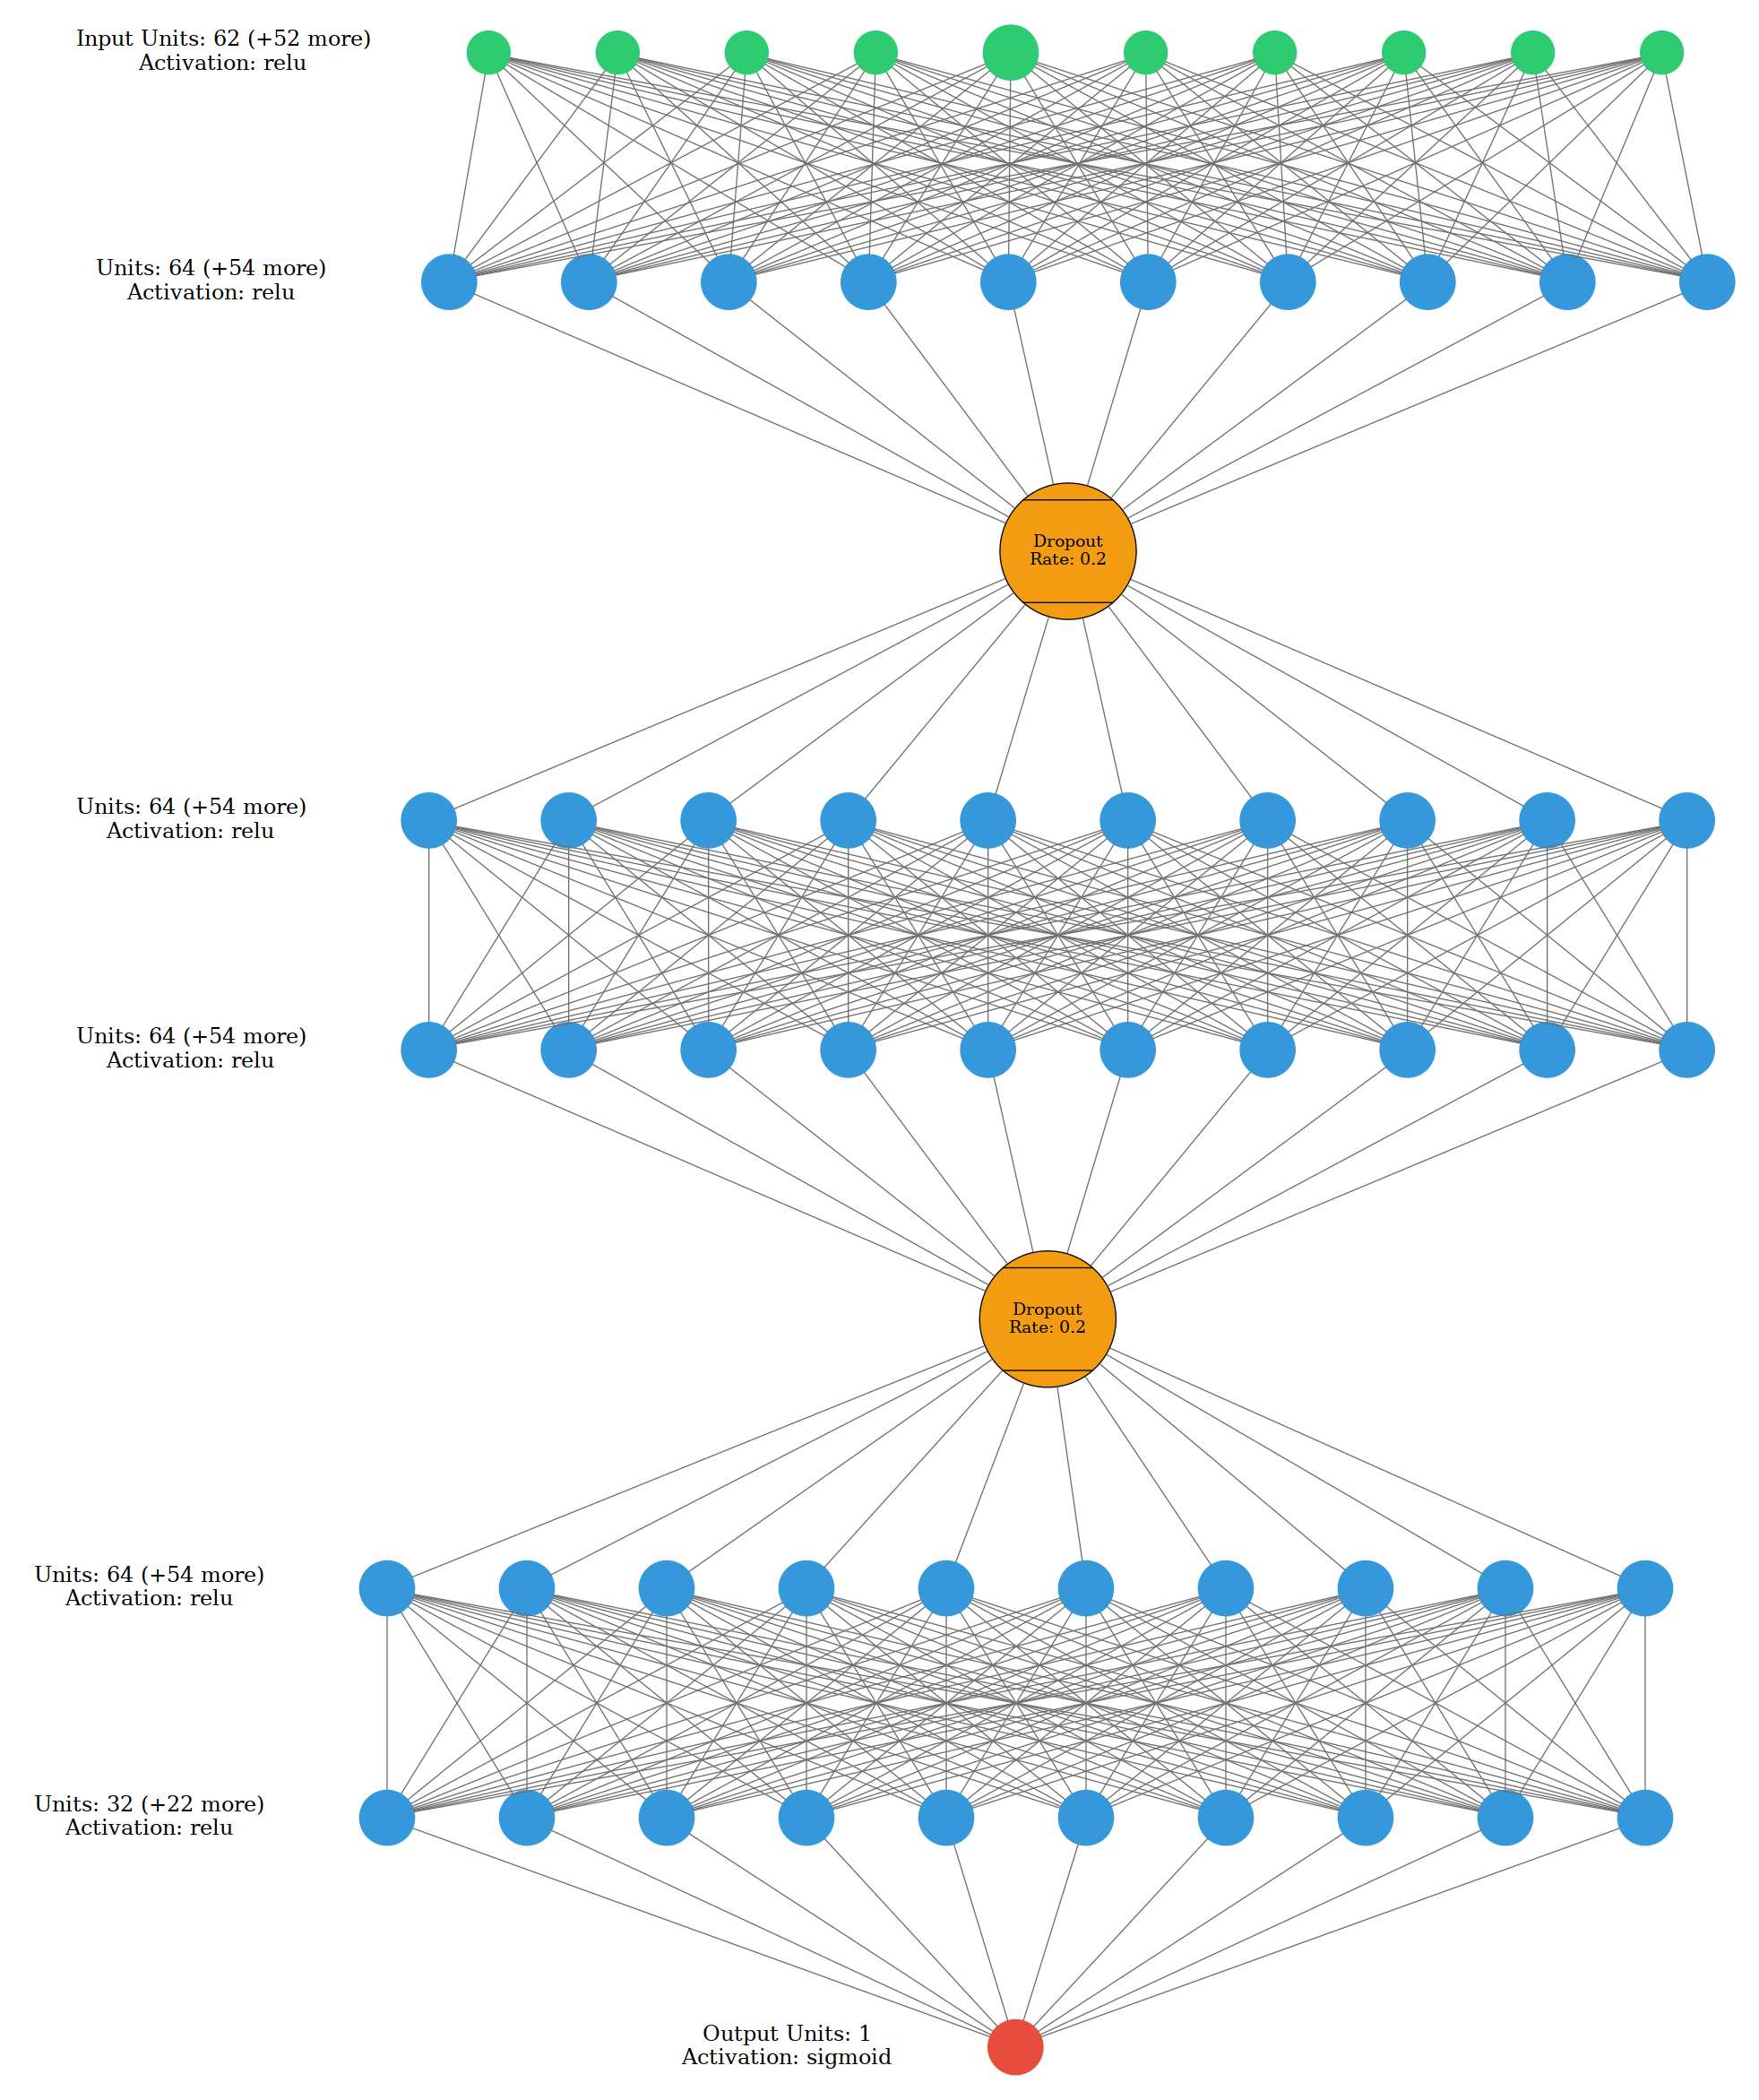

In [31]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [32]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=150,
    validation_data=(X_test, Y_test)  # Provide validation data
)

Epoch 1/150
2572/2572 [==============================] - 9s 3ms/step - loss: 0.0900 - precision_2: 0.9667 - recall_2: 0.9666 - auc_2: 0.9947 - val_loss: 0.0597 - val_precision_2: 0.9818 - val_recall_2: 0.9754 - val_auc_2: 0.9975
Epoch 2/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0644 - precision_2: 0.9782 - recall_2: 0.9757 - auc_2: 0.9970 - val_loss: 0.0563 - val_precision_2: 0.9828 - val_recall_2: 0.9769 - val_auc_2: 0.9979
Epoch 3/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0609 - precision_2: 0.9794 - recall_2: 0.9770 - auc_2: 0.9973 - val_loss: 0.0550 - val_precision_2: 0.9836 - val_recall_2: 0.9767 - val_auc_2: 0.9980
Epoch 4/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0587 - precision_2: 0.9805 - recall_2: 0.9778 - auc_2: 0.9975 - val_loss: 0.0530 - val_precision_2: 0.9863 - val_recall_2: 0.9752 - val_auc_2: 0.9982
Epoch 5/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0573 

Epoch 37/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0478 - precision_2: 0.9832 - recall_2: 0.9825 - auc_2: 0.9983 - val_loss: 0.0467 - val_precision_2: 0.9877 - val_recall_2: 0.9790 - val_auc_2: 0.9987
Epoch 38/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0479 - precision_2: 0.9832 - recall_2: 0.9826 - auc_2: 0.9983 - val_loss: 0.0477 - val_precision_2: 0.9865 - val_recall_2: 0.9808 - val_auc_2: 0.9987
Epoch 39/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0477 - precision_2: 0.9833 - recall_2: 0.9825 - auc_2: 0.9983 - val_loss: 0.0459 - val_precision_2: 0.9867 - val_recall_2: 0.9809 - val_auc_2: 0.9986
Epoch 40/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0476 - precision_2: 0.9834 - recall_2: 0.9826 - auc_2: 0.9983 - val_loss: 0.0454 - val_precision_2: 0.9869 - val_recall_2: 0.9806 - val_auc_2: 0.9986
Epoch 41/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.

Epoch 73/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0456 - precision_2: 0.9837 - recall_2: 0.9834 - auc_2: 0.9984 - val_loss: 0.0464 - val_precision_2: 0.9880 - val_recall_2: 0.9796 - val_auc_2: 0.9987
Epoch 74/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0456 - precision_2: 0.9837 - recall_2: 0.9835 - auc_2: 0.9984 - val_loss: 0.0463 - val_precision_2: 0.9876 - val_recall_2: 0.9804 - val_auc_2: 0.9988
Epoch 75/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0454 - precision_2: 0.9838 - recall_2: 0.9836 - auc_2: 0.9984 - val_loss: 0.0465 - val_precision_2: 0.9849 - val_recall_2: 0.9841 - val_auc_2: 0.9988
Epoch 76/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0453 - precision_2: 0.9838 - recall_2: 0.9835 - auc_2: 0.9984 - val_loss: 0.0451 - val_precision_2: 0.9861 - val_recall_2: 0.9834 - val_auc_2: 0.9988
Epoch 77/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.

2572/2572 [==============================] - 7s 3ms/step - loss: 0.0436 - precision_2: 0.9847 - recall_2: 0.9839 - auc_2: 0.9985 - val_loss: 0.0438 - val_precision_2: 0.9857 - val_recall_2: 0.9849 - val_auc_2: 0.9989
Epoch 144/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0435 - precision_2: 0.9843 - recall_2: 0.9842 - auc_2: 0.9986 - val_loss: 0.0438 - val_precision_2: 0.9861 - val_recall_2: 0.9845 - val_auc_2: 0.9989
Epoch 145/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0435 - precision_2: 0.9844 - recall_2: 0.9845 - auc_2: 0.9986 - val_loss: 0.0438 - val_precision_2: 0.9851 - val_recall_2: 0.9853 - val_auc_2: 0.9989
Epoch 146/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0434 - precision_2: 0.9845 - recall_2: 0.9843 - auc_2: 0.9986 - val_loss: 0.0440 - val_precision_2: 0.9862 - val_recall_2: 0.9837 - val_auc_2: 0.9988
Epoch 147/150
2572/2572 [==============================] - 7s 3ms/step - loss: 0.0435 - pr

# Save the model

In [33]:
model.save('dga-binary-model.keras')

dict_keys(['loss', 'precision_2', 'recall_2', 'auc_2', 'val_loss', 'val_precision_2', 'val_recall_2', 'val_auc_2'])


# Display training results

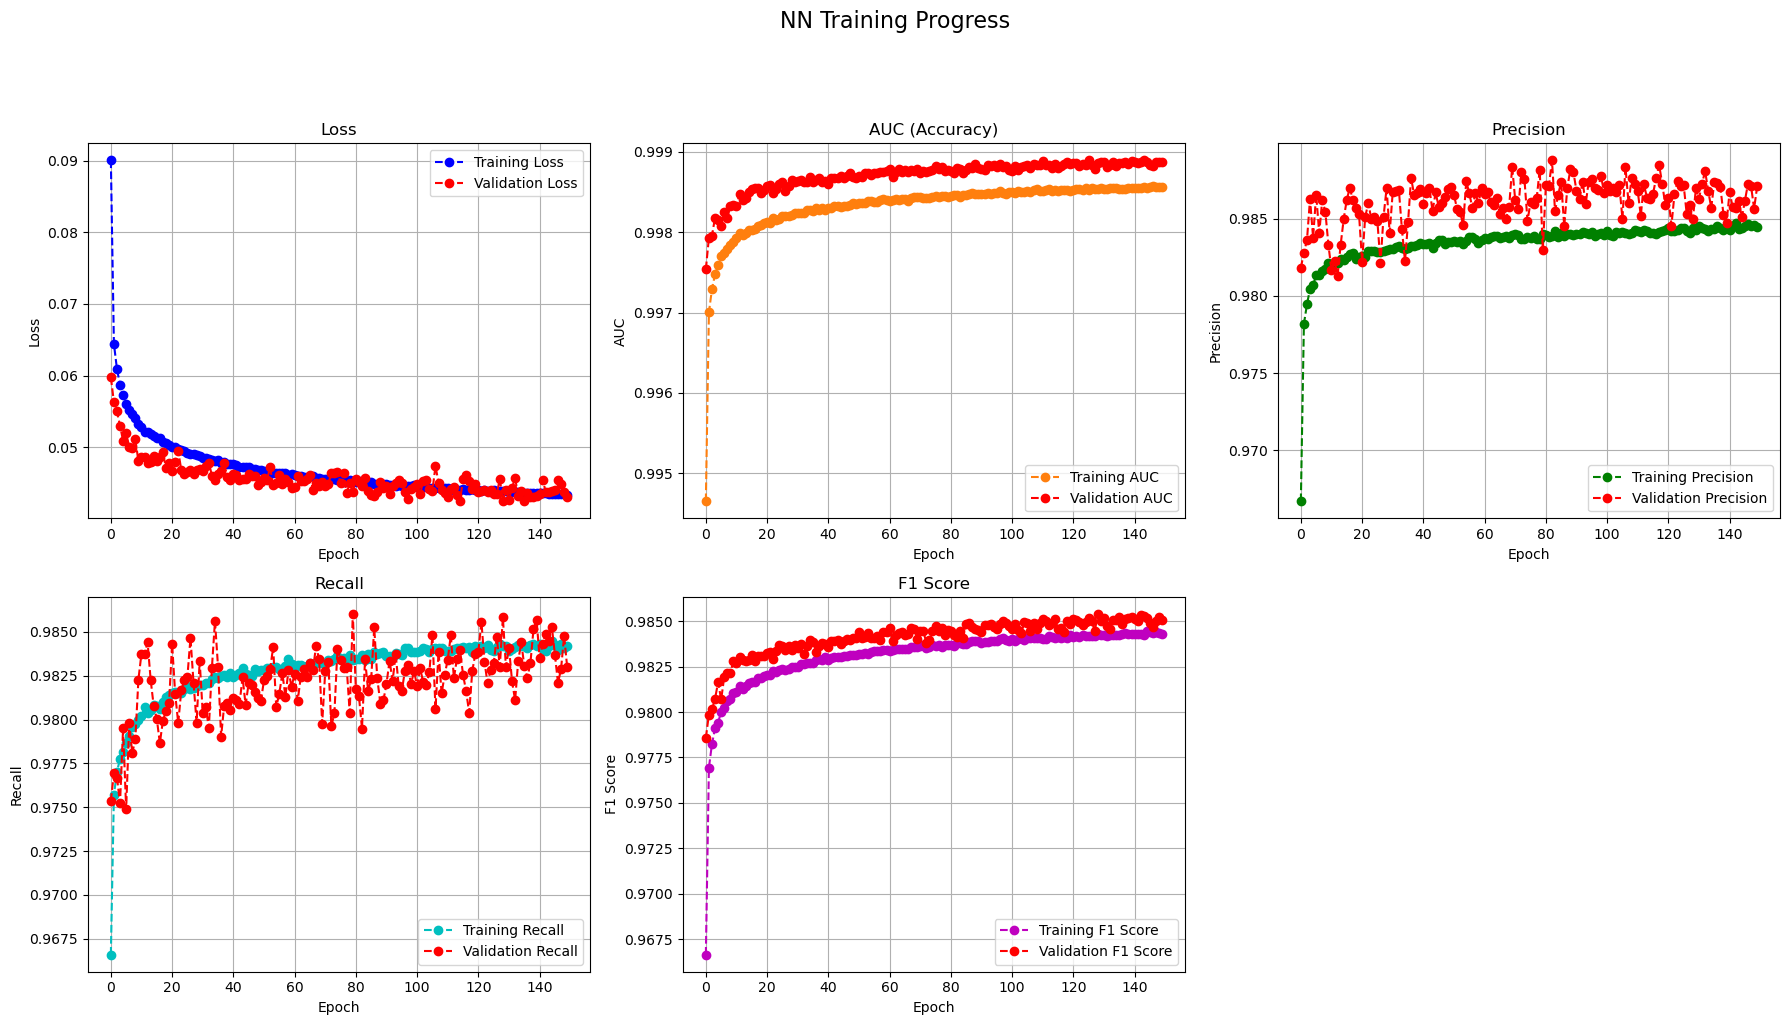

In [38]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score
epoch_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

10287/10287 [==============================] - 14s 1ms/step - loss: 0.0431 - precision_2: 0.9871 - recall_2: 0.9830 - auc_2: 0.9989
Loss =  0.04310214892029762
Accuracy =  0.9871090054512024
10287/10287 [==============================] - 9s 872us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.9828    0.9869    0.9848    163104
   Malicious     0.9871    0.9830    0.9850    166079

    accuracy                         0.9849    329183
   macro avg     0.9849    0.9850    0.9849    329183
weighted avg     0.9850    0.9849    0.9849    329183

False Positive Rate = 0.013071414557582891

Confusion Matrix:
[[160972   2132]
 [  2824 163255]]


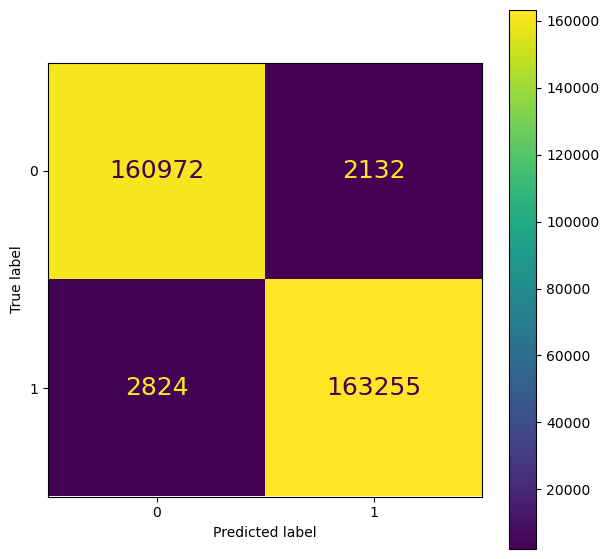

In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

# Feature Importance Analysis

Permutation explainer: 1001it [00:31, 21.66it/s]                                                                                                                                              
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


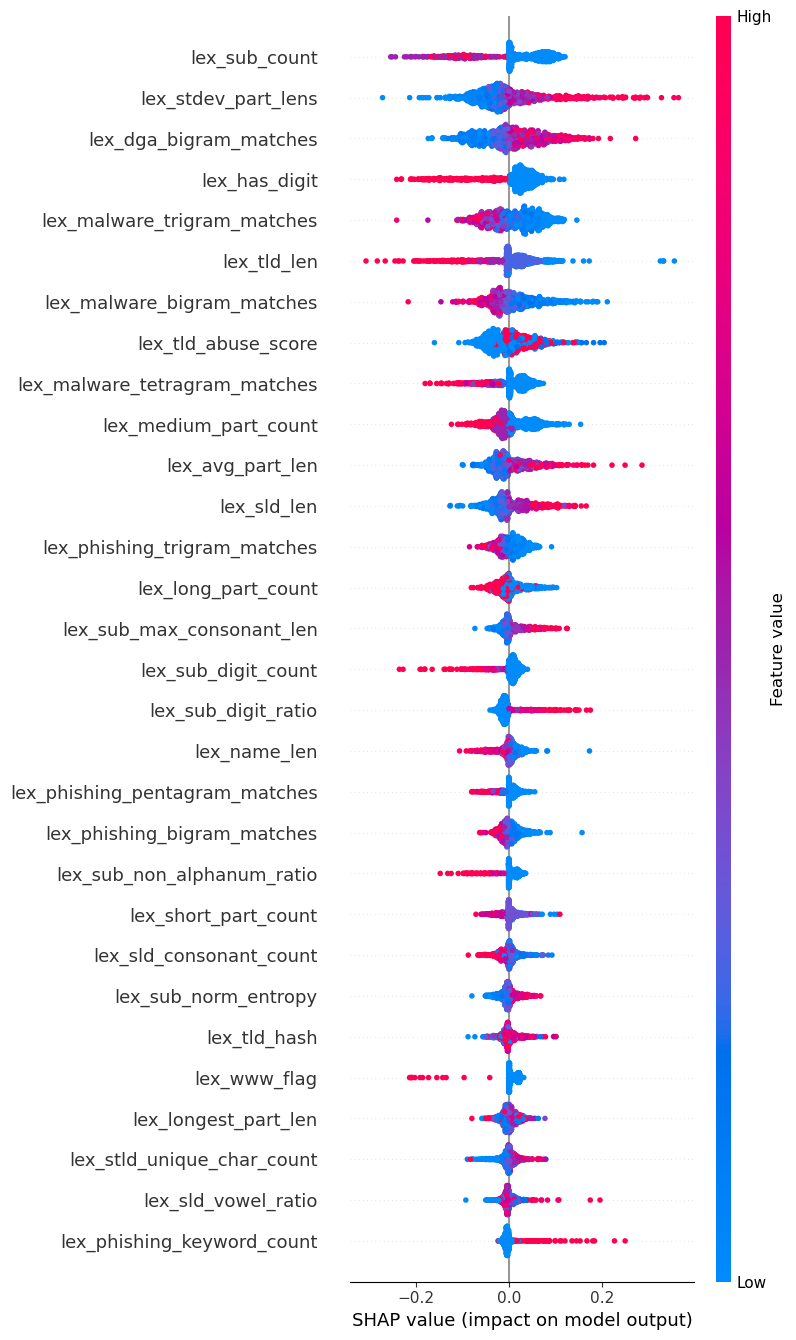

In [36]:
import shap

# Ensure that X_train and X_test are DataFrames with the correct column names
# You can set the column names from the 'features' DataFrame like this:
X_train.columns = features.columns
X_test.columns = features.columns

n_samples = 1000

# Convert your training set to a NumPy format if it's not already
background = X_train[:n_samples].to_numpy()

# Use the generic SHAP Explainer interface
explainer = shap.Explainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer(X_test[:n_samples].to_numpy())

# Plotting the summary plot for feature importance
# Use the column names from the 'features' DataFrame as the feature names
shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)


# Make test predictions

In [39]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model('dga_binary_model.keras')
scaler = joblib.load("dga_binary_scaler.joblib")

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/lex-benign_2312_anonymized.parquet',
    '../feature-extraction/floor/lex-umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "dga"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! DGA !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")




WRONG | mydplr.com (benign), Predicted: !!! DGA !!!, Prob: [[0.95111185]]
OK | ltcubkijmprj.click (dga), Predicted: !!! DGA !!!, Prob: [[0.9235449]]
OK | ghklxsmbipso.kz (dga), Predicted: !!! DGA !!!, Prob: [[0.9859533]]
OK | carenutrition.ltd (benign), Predicted: BENIGN, Prob: [[0.01042778]]
OK | efutro.com.pl (benign), Predicted: BENIGN, Prob: [[0.00281183]]
OK | 40z1phj21c9q1j8s2njvlcwv.net (dga), Predicted: !!! DGA !!!, Prob: [[0.99993265]]
OK | tyie5vojzbhdpx3k.net (dga), Predicted: !!! DGA !!!, Prob: [[0.9990773]]
OK | j6d3e82158446666d8b2bc99e5bbb0943f.cn (dga), Predicted: !!! DGA !!!, Prob: [[0.9996717]]
OK | tu3ydh1c5fvq91ao5kskes9tkn.net (dga), Predicted: !!! DGA !!!, Prob: [[0.9999678]]
OK | 21cc200af9c07acd954d36c44434aa58.info (dga), Predicted: !!! DGA !!!, Prob: [[0.9989422]]
OK | itktup.com (dga), Predicted: !!! DGA !!!, Prob: [[0.95344853]]
OK | servercentral.net (benign), Predicted: BENIGN, Prob: [[0.02206005]]
OK | pnrules.netcoresmartech.com (benign), Predicted: BENI

OK | www.boyfriendtv.com (benign), Predicted: BENIGN, Prob: [[3.799326e-15]]
OK | media.zigcdn.com (benign), Predicted: BENIGN, Prob: [[1.6153743e-07]]
OK | ywnkmmlojqmqlosyahhtjqd.info (dga), Predicted: !!! DGA !!!, Prob: [[1.]]
OK | 2v1rz2dd8l8o3yn14i1m411vv.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9998344]]
OK | nyumc.webex.com (benign), Predicted: BENIGN, Prob: [[2.5706553e-05]]
OK | ocxeno.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9671734]]
OK | eu.ipv4.dotomi.weighted.com.akadns.net (benign), Predicted: BENIGN, Prob: [[0.]]
OK | cxxxfthnlnbuio.org (dga), Predicted: !!! DGA !!!, Prob: [[0.999995]]
OK | agentserviceapi.trafficmanager.net (benign), Predicted: BENIGN, Prob: [[1.7816866e-15]]
OK | wsaz.com (benign), Predicted: BENIGN, Prob: [[0.02485087]]
OK | elijahlab.haifa.ac.il (benign), Predicted: BENIGN, Prob: [[7.044765e-17]]
OK | ijznga.com (dga), Predicted: !!! DGA !!!, Prob: [[0.98130876]]
OK | mowdylksorvfrai.ir (dga), Predicted: !!! DGA !!!, Prob: [[0.96586865]]
OK 

OK | support.myhermes.co.uk (benign), Predicted: BENIGN, Prob: [[3.7652226e-35]]
OK | qezuwi1uhcyw61oj46i41fa8za8.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9999933]]
OK | 133.xg4ken.com (benign), Predicted: BENIGN, Prob: [[0.00021088]]
OK | derozepoort.amsterdam (benign), Predicted: BENIGN, Prob: [[1.7357115e-13]]
WRONG | exness.com (benign), Predicted: !!! DGA !!!, Prob: [[0.8341815]]
OK | tivvbkffbdofxavad.to (dga), Predicted: !!! DGA !!!, Prob: [[0.9998361]]
OK | ch24rqgytwmhosodu11y8hz95.org (dga), Predicted: !!! DGA !!!, Prob: [[0.99994075]]
OK | vca.com (benign), Predicted: BENIGN, Prob: [[0.0046461]]
OK | arkadium.com (benign), Predicted: BENIGN, Prob: [[0.08184565]]
OK | enutlpiokwc.com (dga), Predicted: !!! DGA !!!, Prob: [[0.83447474]]
OK | kquas61d8m2y91yufu0lq8rlsl.org (dga), Predicted: !!! DGA !!!, Prob: [[0.9999956]]
OK | swin.bet (benign), Predicted: BENIGN, Prob: [[0.01203865]]
OK | husvhvmqvvfupghv.biz (dga), Predicted: !!! DGA !!!, Prob: [[0.9999895]]
OK | kmsifu.c

OK | tube-2.xvideo.party (benign), Predicted: BENIGN, Prob: [[3.3207368e-17]]
OK | sportmas.bike (benign), Predicted: BENIGN, Prob: [[1.4945806e-05]]
OK | journals.epu.edu.iq (benign), Predicted: BENIGN, Prob: [[4.2451488e-17]]
OK | gurmans.dp.ua (benign), Predicted: BENIGN, Prob: [[3.2404896e-05]]
OK | avedesign.studio (benign), Predicted: BENIGN, Prob: [[3.3500016e-06]]
OK | cyberlab.sutd.edu.sg (benign), Predicted: BENIGN, Prob: [[3.9096804e-17]]
OK | gbo9dbcl547j19nah661alcwtl.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9996364]]
OK | xruzkonkxwntdmpikq.org (dga), Predicted: !!! DGA !!!, Prob: [[0.9999989]]
OK | east.smtp.mx.exch091.serverdata.net (benign), Predicted: BENIGN, Prob: [[0.]]
OK | triagon.mt (benign), Predicted: BENIGN, Prob: [[0.01530445]]
OK | myvwnbtqeswsox.com (dga), Predicted: !!! DGA !!!, Prob: [[0.99982136]]
OK | hypo.com.ro (benign), Predicted: BENIGN, Prob: [[0.17475085]]
OK | qbogvahnlk.biz (dga), Predicted: !!! DGA !!!, Prob: [[0.99622726]]
OK | sqgnkxbvvhb

OK | iagurf.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9104787]]
OK | chavez.salkeiz.k12.or.us (benign), Predicted: BENIGN, Prob: [[9.879189e-33]]
OK | p-lb.cdtx.co (benign), Predicted: BENIGN, Prob: [[6.2895306e-06]]
OK | p178d042a174871f97bf01ad5b8c2261a1.so (dga), Predicted: !!! DGA !!!, Prob: [[0.99965143]]
OK | i0.tagstat.com (benign), Predicted: BENIGN, Prob: [[7.87963e-07]]
OK | ybf3ei17fm4lo1jr967e1046mr9.net (dga), Predicted: !!! DGA !!!, Prob: [[0.999962]]
OK | ioyldrwmhsmtlj.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9999975]]
OK | vekeualav.name (dga), Predicted: !!! DGA !!!, Prob: [[0.9956891]]
OK | ringwoodsc.vic.edu.au (benign), Predicted: BENIGN, Prob: [[4.456764e-15]]
OK | apps.profitihub.com (benign), Predicted: BENIGN, Prob: [[6.527985e-08]]
OK | sxyxeho.ru (dga), Predicted: !!! DGA !!!, Prob: [[0.93510205]]
OK | xcrixa.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9786981]]
OK | fcf71aea67fd6ff05fcf8412236bcffc.info (dga), Predicted: !!! DGA !!!, Prob: [[0.999417